In [2]:
# %%
import json
import os
from collections import defaultdict
from glob import glob
import h5py
import matplotlib.pyplot as plt
import numpy as np
import silx.io as io
from PIL import Image
from skimage.exposure import rescale_intensity
from tqdm import tqdm

"""
The following is the full structure of the HDf5:

    data.h5
      |___ exchange
      |       |___ data: float, 4D array
      |                  [n_rotation_angles, n_diffraction_spots, image_size_y, image_size_x]
      |
      |___ metadata
              |___ energy_ev: scalar, float. Beam energy in eV
              |___ probe_pos_px: float, [n_diffraction_spots, 2].
              |                  Probe positions (y, x) in pixel.
              |___ psize_cm: scalar, float. Sample-plane pixel size in cm.
              |___ free_prop_cm: (optional) scalar or array
              |                  Distance between sample exiting plane and detector.
              |                  For far-field propagation, do not include this item.
              |___ slice_pos_cm: (optional) float, 1D array
                                 Position of each slice in sparse multislice ptychography. Starts from 0.
"""


def to_h5(h5_path, h5_name, data, metadata):
    """
    Save data and metadata to HDF5.

    Parameters
    ----------
    h5_path: str
        Path to the HDF5 file.
    h5_name: str
        Name of the HDF5 file.
    data: float, 4D array
        [n_rotation_angles, n_diffraction_spots, image_size_y, image_size_x]
    metadata: dict
        Dictionary of metadata.
    """
    with h5py.File(os.path.join(h5_path, h5_name), "w") as f:
        f.create_dataset(
            "exchange/data", data=data, compression="gzip", compression_opts=9
        )
        for k, v in metadata.items():
            f.create_dataset(f"metadata/{k}", data=v)


def from_edf(path, prefix):
    """Extract data and metadata from EDF files.

    Args:
        path (str): Path to the folder containing the EDF files.
        prefix (str): Prefix of the EDF files.
    """

    if not path.endswith("/"):
        path += "/"
    if not prefix.endswith("_"):
        prefix += "_"

    distances = [int(x.split("_")[-2]) for x in glob(f"{path}{prefix}*_")]
    distances.sort()

    angles = [
        int(x.split("_")[-2])
        for x in glob(f"{path}{prefix}{distances[0]}_/{prefix}{distances[0]}*.edf")
    ]
    angles.sort()

    for i, a in enumerate(angles):
        # srots = []
        sxs = []
        sys = []
        # szs = []
        for j, d in enumerate(distances):
            raw = io.open(f"{path}{prefix}{d}_/{prefix}{d}_{str(a).zfill(4)}.edf")
            raw = raw[list(raw.keys())[0]]  # first/only key should be 'scan_0' normally
            if i == 0 and j == 0:
                data = np.zeros((len(angles), len(distances), *raw.shape))
            data[i, j] = np.array(raw)
            # srots.append(raw["instrument"]["positioners"]["srot"][:])
            sxs.append(raw["instrument"]["positioners"]["sx"][:])
            sys.append(raw["instrument"]["positioners"]["sy"][:])
            # szs.append(raw["instrument"]["positioners"]["sz"][:])

        if i == 0:
            metadata = {
                # get the energy
                "energy_ev": raw["instrument"]["detector_0"]["others"]["energy"][0],
                # get the probe positions
                "probe_pos_px": np.array([[x, y] for x, y in zip(sys, sxs)]),
                # get the pixel size
                "psize_cm": raw["instrument"]["detector_0"]["others"]["pixel_size"][0]
                * 1e-7,
                # # get the free propagation distance
                # "free_prop_cm": raw["instrument"]["detector_0"]["distance"][0] * 1e-7,
                # # get the slice positions
                # "slice_pos_cm": np.unique(szs)
            }

    return data, metadata


def edf_to_h5(
    path,
    prefix,
    h5_path,
    h5_name,
    # probe_pos_px,
    # psize_cm,
    free_prop_cm=None,
    slice_pos_cm=None,
):
    """
    Convert EDF files to HDF5.

    Parameters
    ----------
    path: str
        Path to the folder containing the EDF files.
    prefix: str
        Prefix of the EDF files.
    h5_path: str
        Path to the HDF5 file.
    h5_name: str
        Name of the HDF5 file.
    probe_pos_px: float, [n_diffraction_spots, 2]
        Probe positions (y, x) in pixel.
    psize_cm: scalar, float
        Sample-plane pixel size in cm.
    free_prop_cm: (optional) scalar or array
        Distance between sample exiting plane and detector.
        For far-field propagation, do not include this item.
    slice_pos_cm: (optional) float, 1D array
        Position of each slice in sparse multislice ptychography. Starts from 0.
    """
    data, metadata = from_edf(path, prefix)
    if free_prop_cm is not None:
        metadata["free_prop_cm"] = free_prop_cm
    if slice_pos_cm is not None:
        metadata["slice_pos_cm"] = slice_pos_cm

    to_h5(h5_path, h5_name, data, metadata)


def get_image_array(edfs):
    mats = []
    for edf in edfs:
        edf = edf[list(edf.keys())[0]]
        mats.append(edf["image"]["data"][:])
    return np.array(mats)


def get_corrected_image_array(data_edfs, empty_edfs=None, dark_edfs=None):
    if dark_edfs is not None:
        dark_avg = get_image_array(dark_edfs).mean(0)
    else:
        dark_avg = 0
    if empty_edfs is not None:
        empty_avg = get_image_array(empty_edfs).mean(0) - dark_avg
    else:
        empty_avg = 1
    data_mat = (get_image_array(data_edfs) - dark_avg) / empty_avg
    return data_mat


def get_positions_dict(
    edfs,
    keys=["srot", "sx", "sy", "sz", "spy", "spz", "ksvo", "ksho", "ksvg", "kshg"],
    old_dict=None,
):
    if old_dict is not None:
        positions = old_dict
    else:
        positions = defaultdict(list)

    for edf in edfs:
        position_edf = edf[list(edf.keys())[0]]["instrument/positioners"]
        for key in keys:
            if key in position_edf.keys():
                positions[key].append(position_edf[key][:][0])
    return positions


# if __name__ == "__main__":
path = "/nrs/funke/rhoadesj/data/XNH/SiemensLH_holonfp_15nm_/"
prefix = "SiemensLH_holonfp_15nm_"
h5_path = "/nrs/funke/rhoadesj/data/XNH/"
h5_name = "SiemensLH_holonfp_15nm.h5"
# # free_prop_cm = 0.5
# # slice_pos_cm = np.arange(0, 0.5, 0.05)
# data, metadata = from_edf(path, prefix)
# # metadata["free_prop_cm"] = free_prop_cm
# # metadata["slice_pos_cm"] = slice_pos_cm
files = glob(f"{path}{prefix}*.edf")
edfs = []
for file in files:
    edfs.append(io.open(file))
dark_edfs = edfs[:20]
data = None
positions = None
for d in range(4):
    start = 21 + d * 38
    data_edfs = edfs[start : start + 17]
    empty_edfs = edfs[start + 17 : start + 38]
    if data is None:
        # data = get_corrected_image_array(data_edfs, empty_edfs, dark_edfs)
        data = get_corrected_image_array(data_edfs, None, dark_edfs)
    else:
        data = np.concatenate(
            # (data, get_corrected_image_array(data_edfs, empty_edfs, dark_edfs))
            (data, get_corrected_image_array(data_edfs, None, dark_edfs))
        )
    if positions is None:
        positions = get_positions_dict(data_edfs)
    else:
        positions = get_positions_dict(data_edfs, old_dict=positions)
data = np.array(data)[None, ...]
temp = edfs[21][list(edfs[21].keys())[0]]
pixel_size = temp["instrument"]["detector_0"]["others"]["pixel_size"][0]

/tmp/ipykernel_2558610/275287489.py:167: RuntimeWarning: invalid value encountered in divide
  data_mat = (get_image_array(data_edfs) - dark_avg) / empty_avg


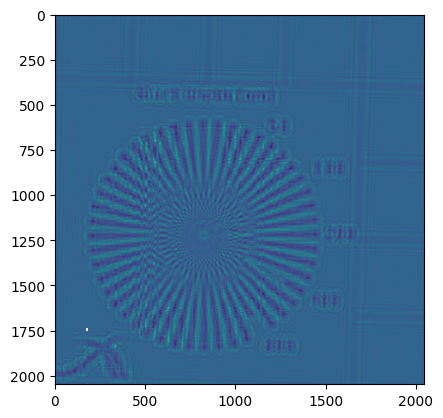

In [6]:
import matplotlib.pyplot as plt

i = np.random.randint(0, 67)
plt.imshow(data[0, i])

# fig, axes = plt.subplots(17, 4, figsize=(5*17, 20))
# for i in range(17):
#     for j in range(4):
#         axes[i, j].imshow(data[0, i+17*j, ...])

In [28]:
metadata = {
    # get the energy
    "energy_ev": temp["instrument"]["detector_0"]["others"]["energy"][0],
    # get the probe positions
    "probe_pos_px": np.array(
        [
            [x / pixel_size, y / pixel_size]
            for x, y in zip(positions["sy"], positions["sx"])
        ]
    ),
    # get the pixel size
    "psize_cm": pixel_size * 1e-7,
    # get the free propagation distance
    "free_prop_cm": np.array(positions["sz"]) * 1e-7,
    # # get the slice positions
    # "slice_pos_cm": np.unique(szs)
}
metadata

{'energy_ev': 17.1,
 'probe_pos_px': array([[ -96.187386,  148.3647  ],
        [ -96.187386,  148.3647  ],
        [ -96.187386,  148.3647  ],
        [ -96.187386,  148.3647  ],
        [ -96.187386,  148.3647  ],
        [ -96.187386,  148.3647  ],
        [ -96.187386,  148.3647  ],
        [ -96.187386,  148.3647  ],
        [ -96.187386,  148.3647  ],
        [ -96.187386,  148.3647  ],
        [ -96.187386,  148.3647  ],
        [ -96.187386,  148.3647  ],
        [ -96.187386,  148.3647  ],
        [ -96.187386,  148.3647  ],
        [ -96.187386,  148.3647  ],
        [ -96.187386,  148.3647  ],
        [ -82.85423 ,  148.3647  ],
        [ -96.680046,  165.43112 ],
        [ -96.680046,  165.43112 ],
        [ -96.680046,  165.43112 ],
        [ -96.680046,  165.43112 ],
        [ -96.680046,  165.43112 ],
        [ -96.680046,  165.43112 ],
        [ -96.680046,  165.43112 ],
        [ -96.680046,  165.43112 ],
        [ -96.680046,  165.43112 ],
        [ -96.680046,  165.4

In [30]:
to_h5(h5_path, h5_name, data, metadata)

In [29]:
data.shape

(1, 68, 2048, 2048)

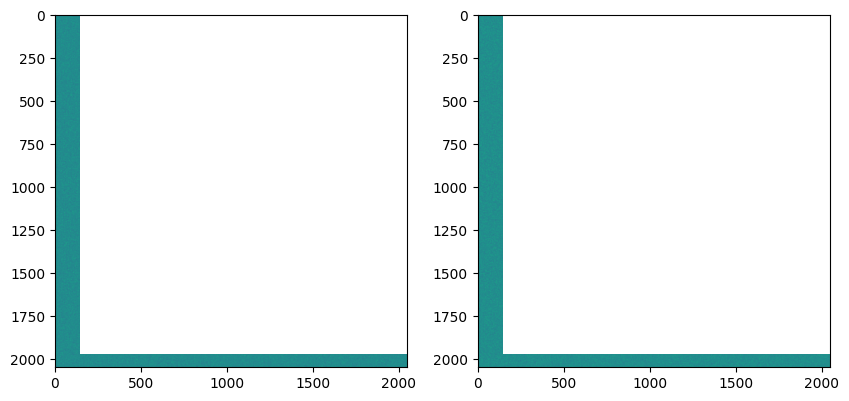

In [2]:
import matplotlib.pyplot as plt
import dxchange.reader as dxreader

iter = 32
phase = dxreader.read_tiff(f"/nrs/funke/rhoadesj/data/XNH/Adorym/SiemensLH_holonfp_15nm_test0/intermediate/object/obj_phase_{iter}_1.tiff")
mag = dxreader.read_tiff(f"/nrs/funke/rhoadesj/data/XNH/Adorym/SiemensLH_holonfp_15nm_test0/intermediate/object/obj_mag_{iter}_1.tiff")

fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].imshow(phase)
axs[1].imshow(mag)
